# Analyse
Im Folgenden befindet sich Code, welcher zur Analyse der Daten verwendet wird.

Dieses Notebook ist aufgeteilt in:
- [Funktionsbereich](#Funktionsbereich)
- [Playground](#Playground-Bereich)
- [Grafiken](#Grafik-Bereich)

## Funktionsbereich
In diesem Bereich befinden sich die Funktionen. Die einzelnen Zellen müssen daher beim Neustart des Notebooks zuerst noch ausgeführt werden, damit die entsprechenden Funktionen im weiteren Verlauf zur Verfügung stehen.

### Bibliotheken
Importieren der notwendigen Bibliotheken

In [1]:
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

### Konstanten
Hier werden verschiedene Konstanten festgelegt. Unter anderem befindet sich hier das Mapping, welches die Probanden IDs auf die Eigenschaften (**Geschlecht** und **Alter**) mappt, um diese in anderen Funktionen
nutzen zu können.

In [3]:
subjects = {
    1: ["male", 52],
    2: ["male", 40],
    3: ["female", 35],
    4: ["female", 44],
    5: ["male", 21],
    6: ["female", 21],
    7: ["male", 51],
    8: ["female", 51],
    9: ["male", 14],
    10: ["male", 23],
    11: ["female", 23],
    12: ["male", 52]
}

words = [
    "51674 Wiehl",
    "53119 Bonn",
    "Musik",
    "Eminem",
    "51063 Koeln",
    "Auto",
    "Radio",
    "Max Muster",
    "WDR 4",
    "Tanken",
    "54290 Trier",
    "Navi",
    "57462 Olpe",
    "02262 Wiehl",
    "Jane Doe",
    "RPR1",
    "Italien",
    "Strasse",
    "SWR3"
]

path_to_data = "../Daten/"
path_to_csvs = "../CSV_Data/"

drea_ids = [1,2,5,7,10,11]
normal_ids = [3,4,6,8,9,12]

### Funktionen
Hier finden sich die Funktionen im Funktionsbereich

In [3]:
# Verwandelt eine Log Datei in eine CSV Datei (vorher muss Fehler Log entfernt werden)
def log_to_csv(*filenames):  
    for filename in filenames:
        if "drea" not in filename and "normal" not in filename:
                continue
        with open(filename, "r") as file:
            _filename = os.path.basename(filename)
            with open(path_to_csvs + _filename.split(".txt")[0] + ".csv", "w", newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=",")
                writer.writerow(["event","timestamp","button","finger","word"])
                for line in file:
                    if "beginning" in line or "Proband" in line:
                        continue

                    data = line.split("{")[1].split("}")[0].split(",")
                    writer.writerow(data)

In [4]:
def get_raw_data():
    files = [path_to_data + file for file in os.listdir(path_to_data)]
    return files

In [5]:
def get_csv_data():
    files = [path_to_csvs + file for file in os.listdir(path_to_csvs)]
    return files

In [6]:
# Wandelt alle Basisdaten von .txt in .csv um
def generate_csv_files():
    log_to_csv(*get_raw_data())

In [7]:
def calc_time(*filenames):
    for filename in filenames:
        data = pd.read_csv(filename)
        start = data.query('event == "TRIAL_START"')["timestamp"]
        end = data.query('event == "TRIAL_END"')["timestamp"]
        time = (int(end) - int(start)) / 1000 / 60
        _filename = os.path.basename(filename).split("-")
        _id = _filename[0]
        mode = _filename[1].split(".")[0]
        yield (_id, mode, round(time, 2))

In [8]:
# Erzeugt ein Dict aus Worten und für das Wort notwendige Aktionen (kann verglichen werden)
def count_actions_for_word(filename):
    word_dict = dict()
    current = None
    data = pd.read_csv(filename)
    queried = data.query('event == "WORD_DONE"')
    sorted = queried.sort_values(by="timestamp", ascending=True)
    for index, row in sorted.iterrows():
        word = row["word"]
        started_index = data.query('event == "WORD_NEXT" and word == @word')
        word_dict[word] = index - started_index.index.values[0]
    return word_dict

In [9]:
# Erzeugt ein Dict aus Worten und für das Wort benötigte Zeit
def count_speed_for_word(*filenames):
    with open(path_to_csvs + "word_speeds.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(["id", "sex", "age", "mode", "word", "length", "time", "actions"])

        for filename in filenames:
            if "drea" not in filename and "normal" not in filename:
                continue
            word_actions = count_actions_for_word(filename)
            old = None
            old_word = None
            counter = 0
            with open(filename, "r") as file:
                for line in file:
                    # Wenn das nächste Wort angezeigt wird
                    if "WORD" in line:
                        data = line.split(",")
                        
                    if "WORD_NEXT" in line:
                        # Test ob es das erste Wort ist
                        if old_word == None:
                            old_word = data
                            continue
                            
                        old_word = data
                        
                    if "WORD_DONE" in line:
                        _id = get_id(filename)
                        mode = get_mode(filename)
                        word = old_word[4].strip()
                        actions = word_actions[word]
                        time = (int(data[1]) - int(old_word[1])) / 1000 
                        csvData = [_id] + subjects[int(_id)] + [mode, word, len(word), time, actions]
                        writer.writerow(csvData)

In [10]:
def get_id(filename):
    _filename = os.path.basename(filename).split("-")
    return int(_filename[0])

In [11]:
def get_mode(filename):
    _filename = os.path.basename(filename).split("-")
    mode = _filename[1].split(".")[0]
    return mode

In [12]:
def speed_by_id(*filenames): 
    for filename in filenames:
        speed = pd.read_csv(path_to_csvs + filename)
        event_filter = speed["event"] == "CHAR_CLICKED"
        inverted = speed[event_filter].sort_values(by="timestamp", ascending=False)
        times = []
        old = None
        for time in inverted["timestamp"]:
            if old == None:
                old = time
                continue
            else:
                times.append((old - time) / 1000)
                old = time
        yield pd.Series(times[::-1])

In [13]:
# Funktion zum Analysieren der Geschwindigkeit der einzelnen Buchstaben

### WICHTIG ### Zu wenig Datenpunkte für eine richtige Analyse ### WICHTIG ###
def get_speed_for_chars(filename):
    data = pd.read_csv(filename)
    trial_start = data[data["event"] == "TRIAL_START"]["timestamp"]
    char_event_filter = data["event"] == "CHAR_CLICKED"
    clicked = data[char_event_filter].sort_values(by="timestamp", ascending=True)
    old = None
    char_dict = dict()
    char_list = []
    for index, row in clicked.iterrows():
        time = row["timestamp"]
        if old == None:
            old = time
            char_list.append([row["button"], (old - int(trial_start)) / 1000, time])
        else:     
            char_list.append([row["button"], (time - old) / 1000, time])
            old = time
    df = pd.DataFrame(char_list, columns=["button", "time", "timestamp"])
    return df

In [14]:
def calc_typing_speed(filename):
    with open(filename, "r") as file:
        old = None
        speeds = []
        for line in file:
            if "CHAR_CLICKED" in line:
                data = line.split(",")
                current = int(data[1])
                if old == None:
                    old = current
                else:
                    speeds.append((current - old) / 1000)
                    old = current
                
    return speeds

In [15]:
def limited_actions(*filenames):
    with open(path_to_csvs + "tpa-tpc.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(["id", "mode", "word", "tpa", "tpc"])
        for filename in filenames:
            if "drea" not in filename and "normal" not in filename:
                continue
            df = pd.read_csv(filename)
            for word in words:
                stamps = get_timestamps(word, df)
                time_limit_events = df.query("timestamp > @stamps[0] and timestamp <= @stamps[1]")
                diff = int(time_limit_events.iloc[-1:]["timestamp"]) - int(time_limit_events.iloc[0]["timestamp"])
                tpa = diff / 1000 / time_limit_events.count()["timestamp"]
                tpc = diff / 1000 / len(word)
                _id = get_id(filename)
                mode = get_mode(filename)
                writer.writerow([_id, mode, word, round(tpa, 2), round(tpc, 2)])

def get_timestamps(word, df):
    last_char = word[-1:].upper()
    start = int(df.query('event == "WORD_NEXT" and word == @word')["timestamp"])
    end_time = int(df.query('event == "WORD_DONE" and word == @word')["timestamp"])
    end = df.query('event == "CHAR_CLICKED" and button == @last_char and timestamp > @start and timestamp < @end_time')["timestamp"]
    
    return start, int(end[-1:])

## Playground Bereich
Hier werden verschiedene Funktionen getestet, und Daten analysiert

In [159]:
generate_csv_files()

In [160]:
#count_speed_for_word(*get_csv_data())
limited_actions(*get_csv_data())

TypeError: cannot convert the series to <class 'int'>

In [ ]:
with open(path_to_csvs + "interactions.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["id", "sex", "age", "actions_drea", "actions_normal", "difference"])

    for i in range(1, 13):
        drea = count_actions_for_word(f"{path_to_csvs}{str(i).zfill(2)}-drea.csv")
        normal = count_actions_for_word(f"{path_to_csvs}{str(i).zfill(2)}-normal.csv")
        drea_counter = 0
        normal_counter = 0
        for key, value in drea.items():
            drea_counter += drea[key]
            normal_counter += normal[key]
        writer.writerow([i] + subjects[i] + [drea_counter, normal_counter, normal_counter - drea_counter])

In [ ]:
interactionData = pd.read_csv(path_to_csvs + "interactions.csv")
#time_filter = interactionData["time"] < 20
#actions_diff = interactionData["actions_drea"] < interactionData["actions_normal"]
interactionData
#_filter = time_filter & mode_filter
#timedata[_filter]
#interactionData[actions_diff]
#interactionData.sort_values(by = "difference", ascending=False)

In [ ]:
timedata = pd.read_csv(path_to_data + "time.csv")
time_filter = timedata["time"] < 20
mode_filter = timedata["mode"] == "drea"

_filter = time_filter & mode_filter
timedata[_filter].sort_values(by = "time")

In [ ]:
with open(path_to_csvs + "time.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["id", "mode", "time", "sex", "age"])
    for i in range(1, 13):
            try:
                filename_drea = f"{path_to_csvs}{str(i).zfill(2)}-drea.csv"
                filename_normal = f"{path_to_csvs}{str(i).zfill(2)}-normal.csv"
                for run in calc_time(filename_drea, filename_normal):
                    subject = list(run) + subjects[i]
                    writer.writerow(subject)
            except:
                print("Fehler")

## Grafik Bereich
Hier werden verschiedene Grafiken erzeugt (z.B. Boxplots) um die Daten zu analysieren

In [ ]:
df = pd.read_csv(path_to_csvs + "word_speeds.csv")
_filter = df["word"] == "Auto"
_filter2 = df["mode"] == "drea"
_filter3 = df["mode"] == "normal"

C:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


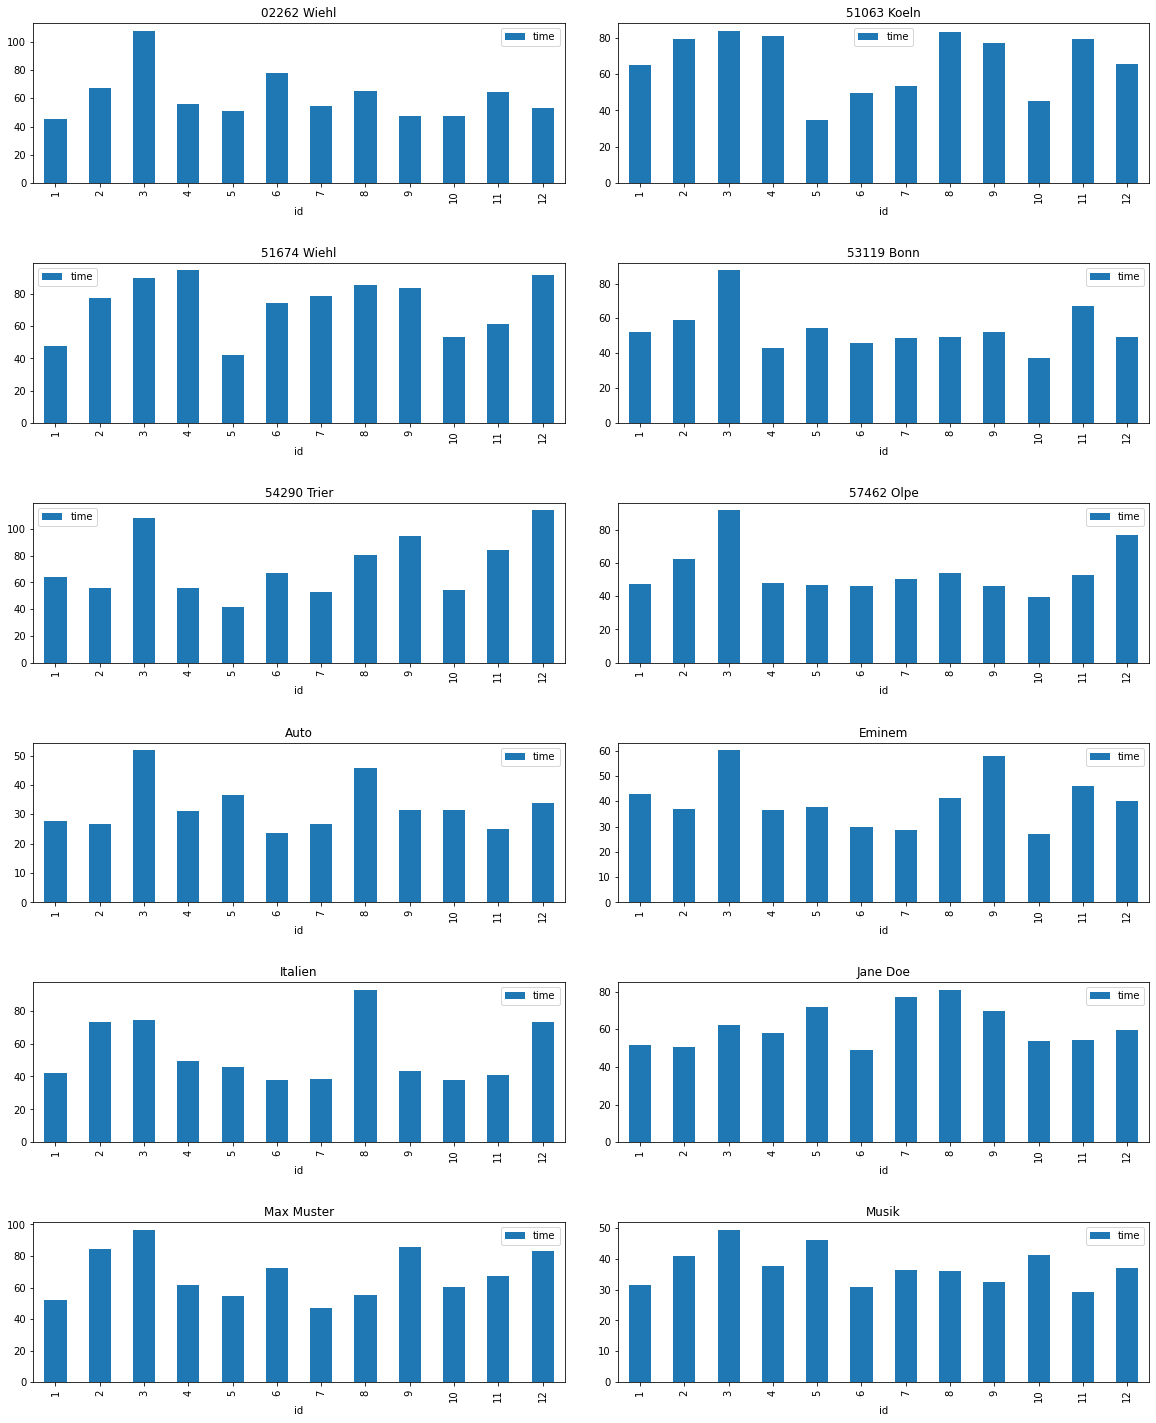

In [ ]:
# Zeigt die Geschwindigkeit nach Proband und Wort (normaler Modus)

fig, ax = plt.subplots(6, 2, figsize=(20,25))
sorted_by_words = df.sort_values(by=["word", "id"])
grouped = sorted_by_words[_filter3].groupby(by="word")
ycounter = 0
xcounter = 0
for name, group in grouped:
    if ycounter == 6:
        break
    group.plot(y="time", x="id", kind="bar", ax=ax[ycounter, xcounter], title=name)
    if xcounter == 1:
        ycounter += 1
        xcounter = 0
    else:
        xcounter += 1
# # print(first.describe())
# # print(last.describe())
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

C:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


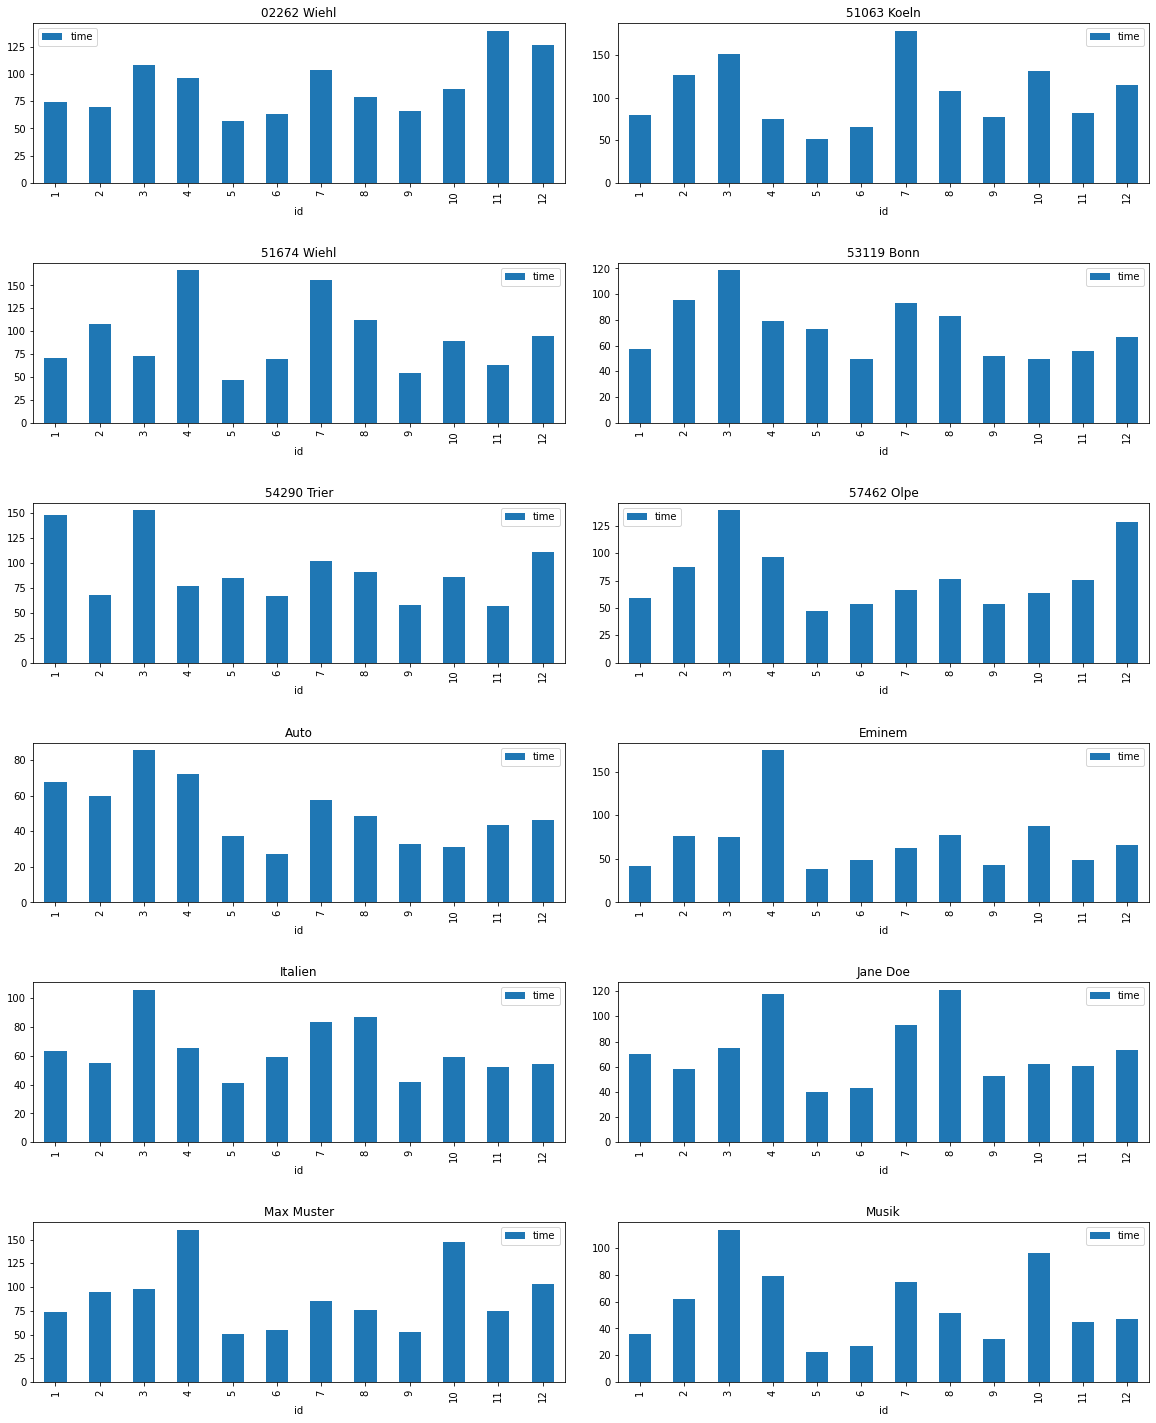

In [ ]:
# Zeigt die Geschwindigkeit nach Proband und Wort (drea Modus)

fig, ax = plt.subplots(6, 2, figsize=(20,25))
sorted_by_words = df.sort_values(by=["word", "id"])
grouped = sorted_by_words[_filter2].groupby(by="word")
ycounter = 0
xcounter = 0
for name, group in grouped:
    if ycounter == 6:
        break
    group.plot(y="time", x="id", kind="bar", ax=ax[ycounter, xcounter], title=name)
    if xcounter == 1:
        ycounter += 1
        xcounter = 0
    else:
        xcounter += 1
# # print(first.describe())
# # print(last.describe())
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

              id        age     length        time     actions
count  60.000000  60.000000  60.000000   60.000000   60.000000
mean    6.500000  35.583333   7.833333   58.593833  109.200000
std     3.481184  14.000353   2.669137   22.782175   31.160492
min     1.000000  14.000000   4.000000   24.659000   43.000000
25%     3.750000  22.500000   5.000000   40.572000   87.000000
50%     6.500000  37.500000   7.000000   53.159500  105.000000
75%     9.250000  51.000000  11.000000   75.154500  134.000000
max    12.000000  52.000000  11.000000  114.024000  179.000000
              id        age     length       time     actions
count  60.000000  60.000000  60.000000  60.000000   60.000000
mean    6.500000  35.583333   6.916667  42.963250   88.683333
std     3.481184  14.000353   2.854029  16.353258   28.598027
min     1.000000  14.000000   4.000000  16.971000   31.000000
25%     3.750000  22.500000   4.000000  30.615000   69.500000
50%     6.500000  37.500000   6.000000  38.464500   91.000000

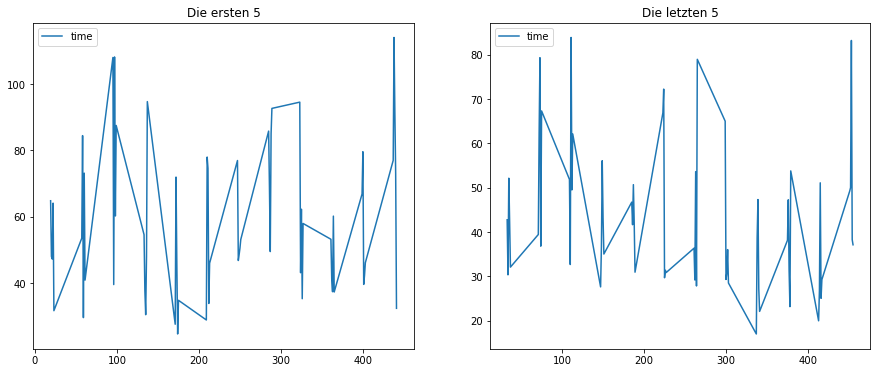

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
grouped = df[_filter3].groupby(by="id")
first = pd.concat([group[:5] for name, group in grouped])
last = pd.concat([group[-5:] for name, group in grouped])
first.plot(y="time", ax=ax[0], title="Die ersten 5")
last.plot(y="time", ax=ax[1], title="Die letzten 5")

print(first.describe())
print(last.describe())
plt.subplots_adjust(wspace=0.2) 
plt.show()

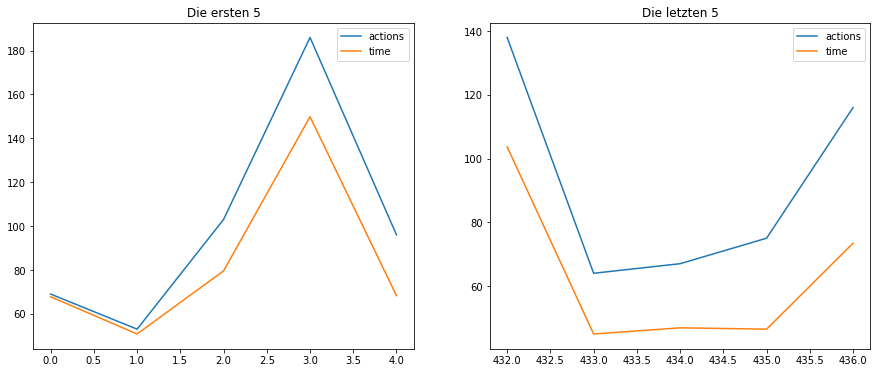

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
df[_filter2][:5].plot(y=["actions", "time"], ax=ax[0], title="Die ersten 5")
df[_filter2][-5:].plot(y=["actions", "time"], ax=ax[1], title="Die letzten 5")
plt.subplots_adjust(wspace=0.2) 

plt.show()

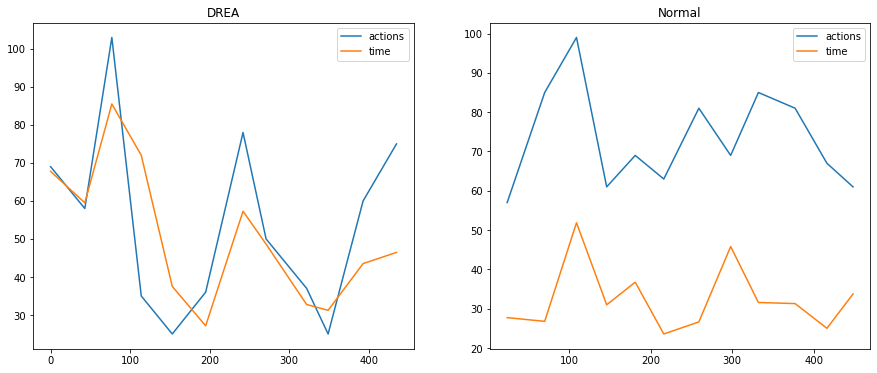

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
df[_filter & _filter2].plot(y=["actions", "time"], ax=ax[0], title="DREA")
df[_filter & _filter3].plot(y=["actions", "time"], ax=ax[1], title="Normal")
plt.subplots_adjust(wspace=0.2) 

plt.show()

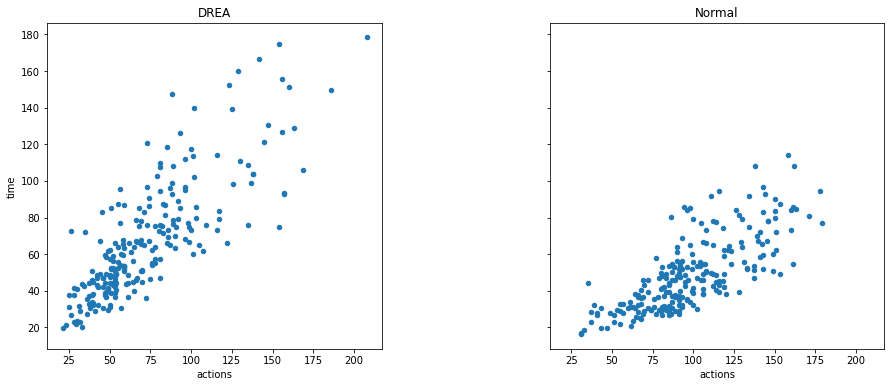

In [ ]:
# Scatter Plot von Actions und Time
# Ein Datenpunkt ist die Zeit und Anzahl an Aktionen für genau 1 Aufgabe
# Zu erkennen ist, dass im DREA Modus mehr Zeit benötigt wurde, sich die Datenpunkte aber vorallem bei 
# weniger Aktionen clustern

# Im normalen Modus hingegen wurde weniger Zeit benötigt, allerdings sammeln sich die Datenpunkt hier bei
# einer höheren Anzahl von Aktionen


fig, ax = plt.subplots(1, 2, figsize=(15,6), sharey=True, sharex=True)
df[_filter2].plot(kind="scatter", x="actions", y="time", ax=ax[0], title="DREA")
df[_filter3].plot(kind="scatter", x="actions", y="time", ax=ax[1], title="Normal")
plt.subplots_adjust(wspace=0.5) 
plt.show()

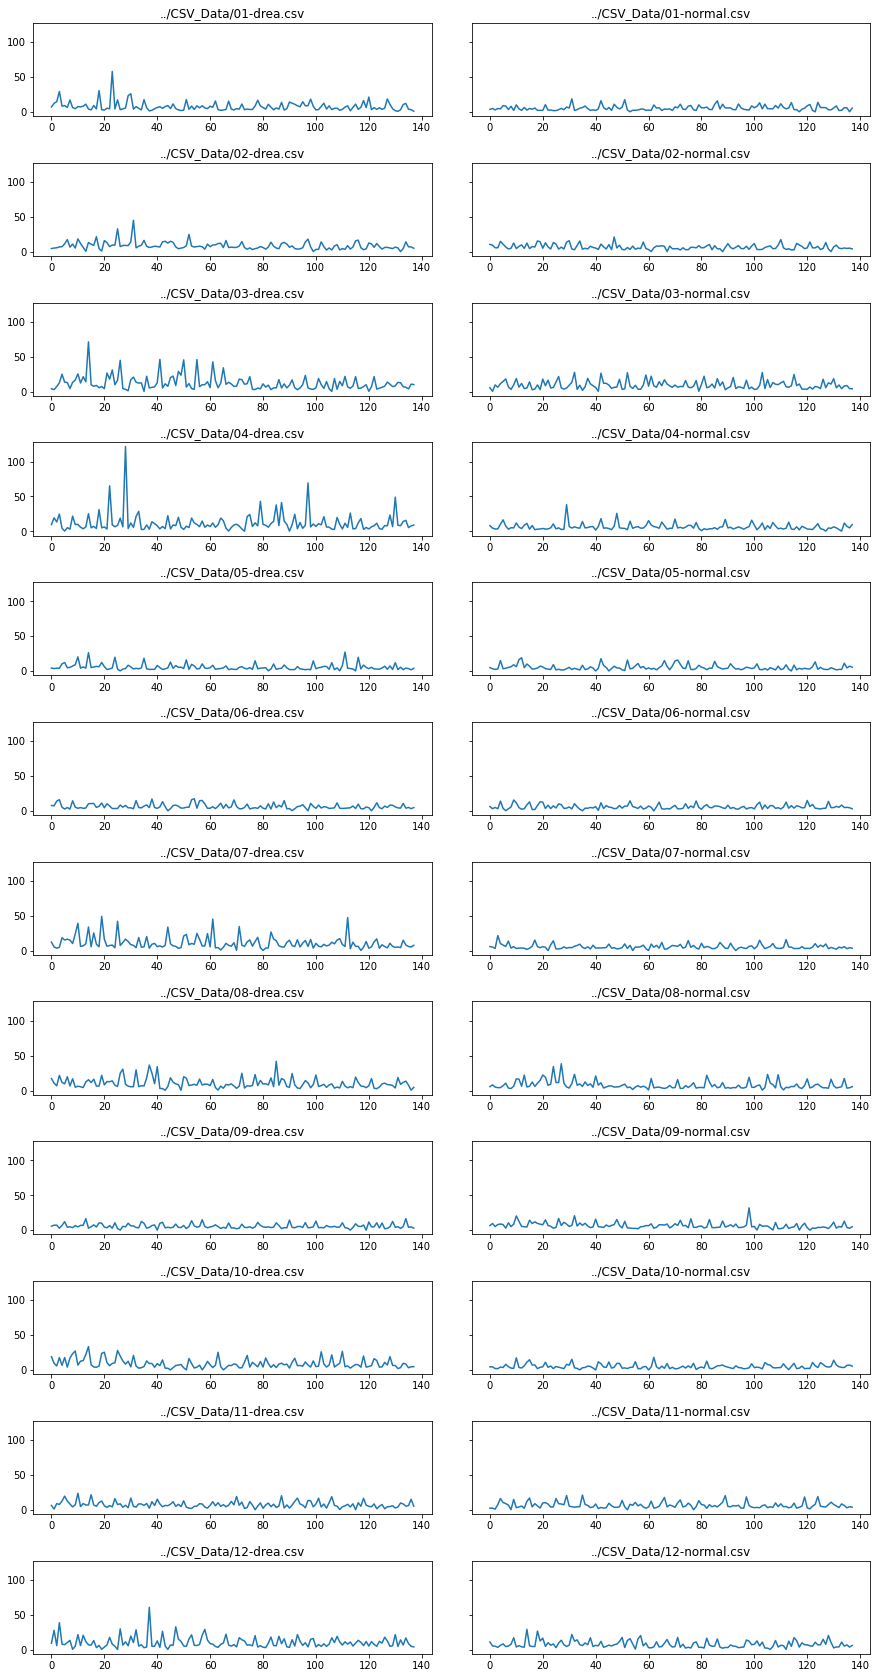

In [ ]:
fig, ax = plt.subplots(12, 2, figsize=(15,30), sharey=True)
files = get_csv_data()
ycounter = 0
xcounter = 0
for file in files:
    if not "drea" in file and not "normal" in file:
        continue
    if xcounter == 2:
        xcounter = 0
        ycounter += 1
        
    data = next(speed_by_id(file))
    data.plot(title=file, ax=ax[ycounter, xcounter])
    xcounter += 1
    
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

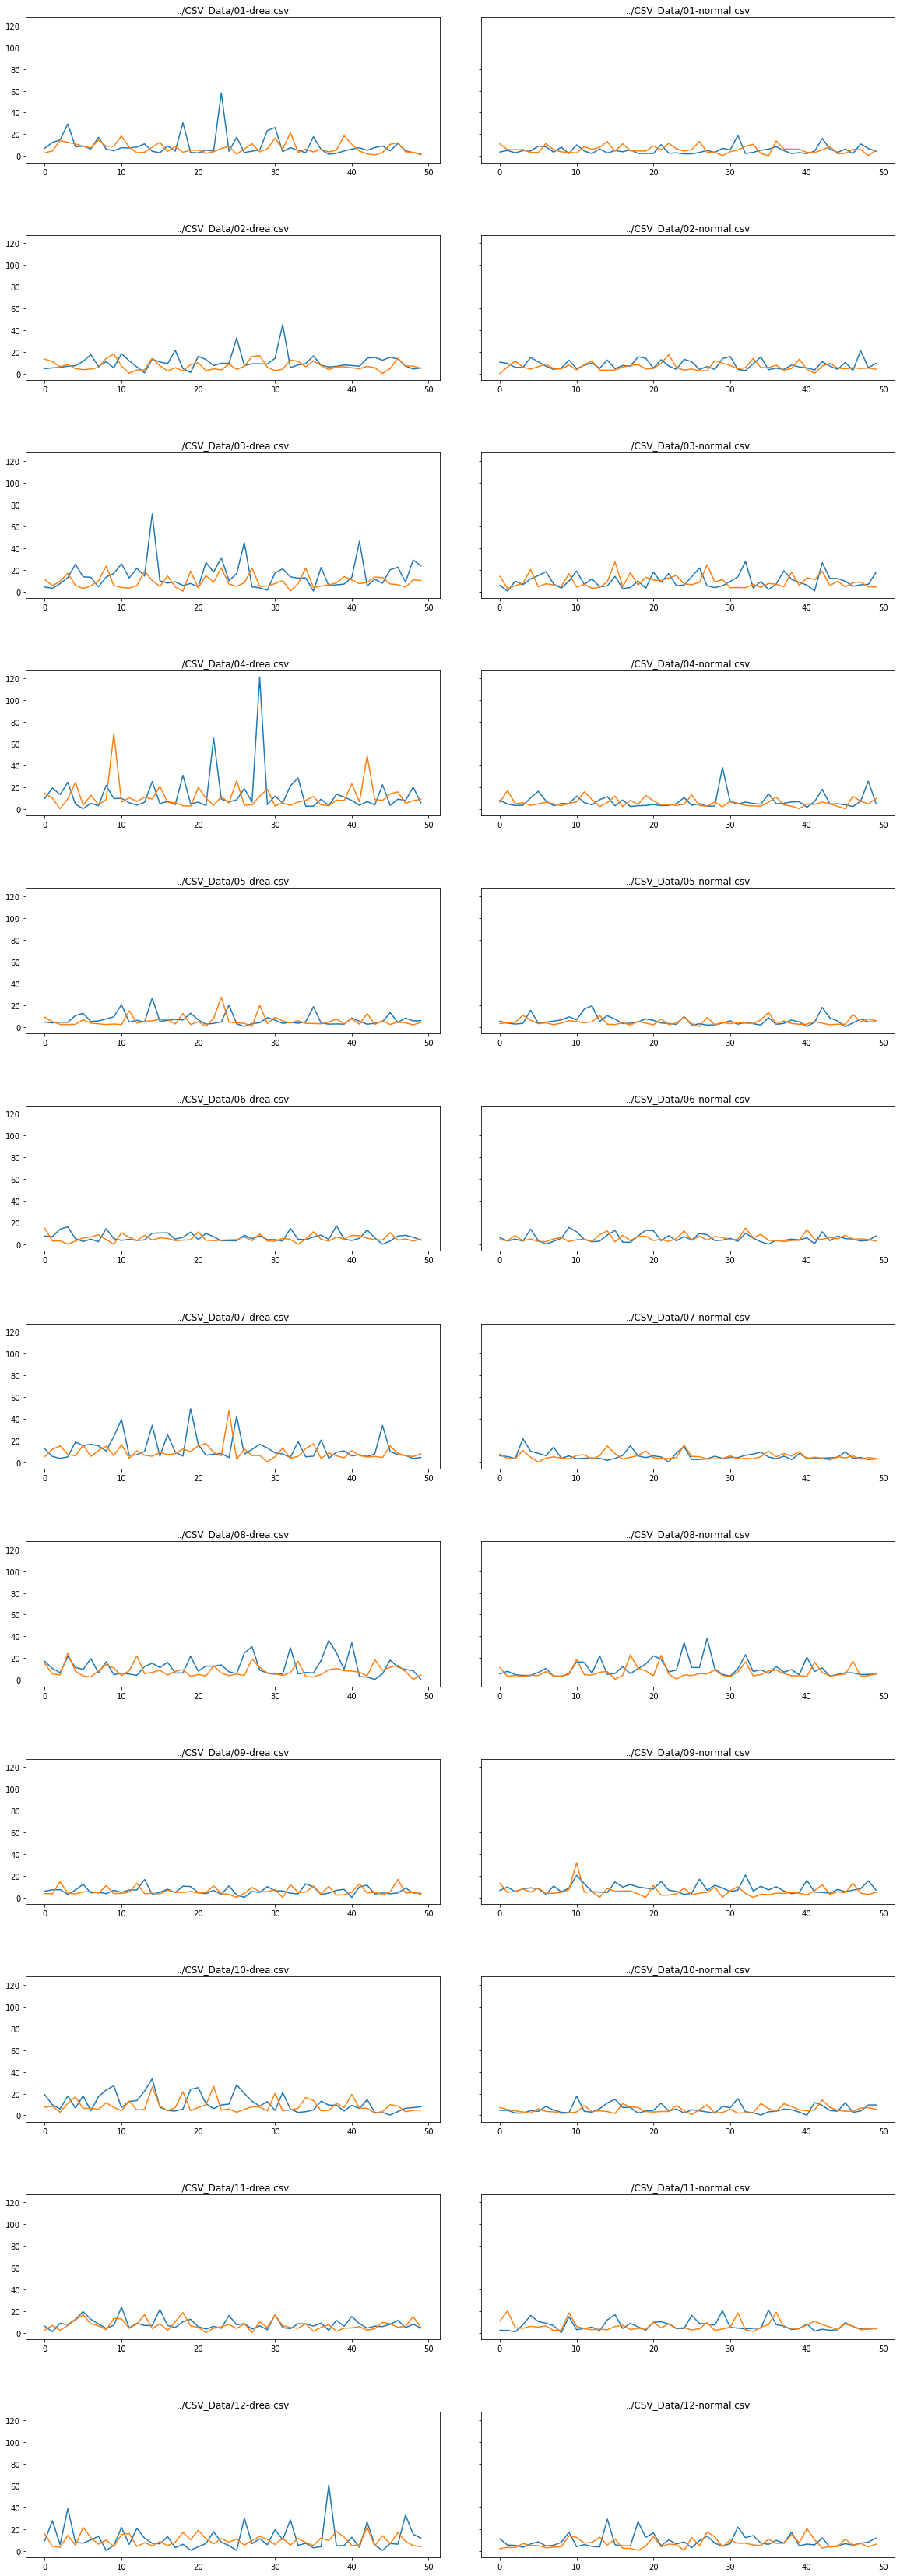

In [ ]:
# Die dargestellten Grafiken zeigen den Geschwindigkeitsverlauf der ersten 50 und der letzten 50 Eingaben. 
# Die blaue Linie stellt dabei die ersten 50, und die orangene Linie die letzten 50 dar.
# Es ist beim DREA ein Lerneffekt zu erkennen, während sich die Kurven der normalen Daten kaum unterscheiden

fig, ax = plt.subplots(12, 2, figsize=(20,60), sharey=True)
ycounter = 0
xcounter = 0
subCounter = 0
files = get_csv_data()

for file in files:
    if not "drea" in file and not "normal" in file:
        continue
        
    if "drea" in file:
        subject_drea = next(speed_by_id(file))
        
        first_drea = subject_drea[:50]
        last_drea = subject_drea[-50:].reset_index(drop=True)

        first_drea.plot(ax=ax[ycounter][0])
        last_drea.plot(ax=ax[ycounter][0], title=file)
        
    if "normal" in file:
        subject_normal = next(speed_by_id(file))
        
        first_normal = subject_normal[:50]
        last_normal = subject_normal[-50:].reset_index(drop=True)

        first_normal.plot(ax=ax[ycounter][1])
        last_normal.plot(ax=ax[ycounter][1], title=file) 
        
    subCounter += 1
    
    if subCounter == 2:
        subCounter = 0
        ycounter += 1

plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

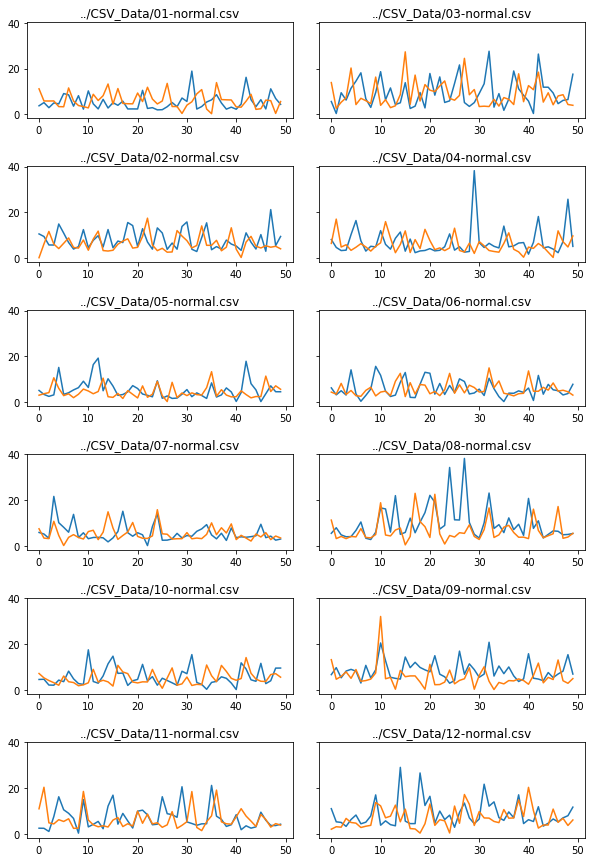

In [166]:
# Die dargestellten Grafiken zeigen den Geschwindigkeitsverlauf der ersten 50 und der letzten 50 Eingaben. 
# Die blaue Linie stellt dabei die ersten 50, und die orangene Linie die letzten 50 dar.
# Es ist beim DREA ein Lerneffekt zu erkennen, während sich die Kurven der normalen Daten kaum unterscheiden

fig, ax = plt.subplots(6, 2, figsize=(10,15), sharey=True)
ycounter = 0
xcounter = 0
subCounter = 0
startd, startn = False, False
files = get_csv_data()

for file in files:
    if not "drea" in file and not "normal" in file:
        continue

    if "drea" in file:
        continue

    _id = get_id(file)
        
    if _id in drea_ids:
        subject_drea = next(speed_by_id(file))
        
        first_drea = subject_drea[:50]
        last_drea = subject_drea[-50:].reset_index(drop=True)

        first_drea.plot(ax=ax[ycounter][0])
        last_drea.plot(ax=ax[ycounter][0], title=file)
        ycounter += 1

ycounter = 0

for file in files:
    if not "drea" in file and not "normal" in file:
        continue

    if "drea" in file:
        continue

    _id = get_id(file)
        
    if _id in normal_ids:
        subject_drea = next(speed_by_id(file))
        
        first_drea = subject_drea[:50]
        last_drea = subject_drea[-50:].reset_index(drop=True)

        first_drea.plot(ax=ax[ycounter][1])
        last_drea.plot(ax=ax[ycounter][1], title=file)
        ycounter += 1

plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

<AxesSubplot:title={'center':'value'}, xlabel='subscale'>

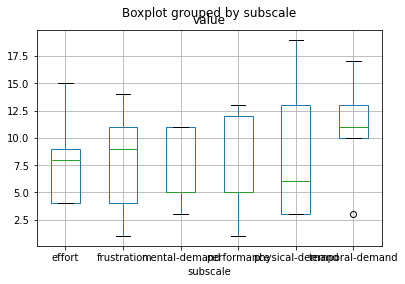

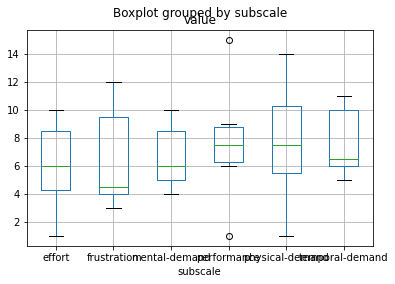

In [99]:
tlx_data = pd.read_csv(path_to_csvs + "tlx.csv")
subjects2 = {
    1: 52,
    2: 40,
    3: 35,
    4: 44,
    5: 21,
    6: 21,
    7: 51,
    8: 51,
    9: 14,
    10: 23,
    11: 23,
    12: 52
}
tlx_data["age"] = tlx_data["subject"].map(subjects2)
tlx_data.query("age < 35 and mode == 'drea'").boxplot("value", by="subscale")
tlx_data.query("age > 35 and mode == 'drea'").boxplot("value", by="subscale")

In [17]:
# Aufschlüsselung nach Personen die im DREA bzw. normalen Modus angefangen haben
# Es wird verglichen, wie diese Personen die unterschiedlichen Skalen empfunden haben
# Frage: Macht es einen Unterschied, ob im DREA oder normalen Modus angefangen wurde?




tlx_data = pd.read_csv(path_to_csvs + "tlx.csv")
drea_filter = tlx_data["mode"] == "drea"
normal_filter = tlx_data["mode"] == "normal"
#scale = tlx_data["subscale"] == "mental-demand"
#filtered = tlx_data[drea_filter].groupby(by="subscale")
# tlx_data[drea_filter].boxplot("value",by="subscale", layout=(2,3), figsize=(30,15))
# tlx_data[normal_filter].boxplot("value",by="subscale", layout=(2,3), figsize=(30,15))
# luca_filter = tlx_data["subject"] == 6
# grouped = tlx_data[luca_filter].groupby("subscale")
# for name, group in grouped:
#     print(group)

tlx_data2 = tlx_data[tlx_data['subject'].isin(drea_ids)]
tlx_data3 = tlx_data[tlx_data['subject'].isin(normal_ids)]

for scale in tlx_data["subscale"].unique():
    scale_filter = tlx_data["subscale"] == scale
    print(f"Scale: {scale}")
    print(tlx_data2[scale_filter & drea_filter]["value"].describe())
    print("\n")
    print(tlx_data3[scale_filter& drea_filter]["value"].describe())
    print("\n")

Scale: mental-demand
count     6.000000
mean     10.833333
std       5.307228
min       4.000000
25%       6.500000
50%      12.000000
75%      14.500000
max      17.000000
Name: value, dtype: float64


count     6.000000
mean      9.166667
std       4.622409
min       3.000000
25%       6.500000
50%       8.500000
75%      12.750000
max      15.000000
Name: value, dtype: float64


Scale: physical-demand
count     6.000000
mean      8.000000
std       7.745967
min       1.000000
25%       1.250000
50%       6.000000
75%      15.250000
max      17.000000
Name: value, dtype: float64


count     6.000000
mean     10.666667
std       4.131182
min       7.000000
25%       7.250000
50%       9.500000
75%      13.250000
max      17.000000
Name: value, dtype: float64


Scale: temporal-demand
count     6.000000
mean      6.666667
std       4.033196
min       2.000000
25%       5.000000
50%       5.000000
75%       8.750000
max      13.000000
Name: value, dtype: float64


count     6.000000
mean

c:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [29]:
grouped = tlx_data.groupby(by="subscale")
for name, group in grouped:
    print("\n" + name)
    print(group.query('mode == "normal"')["value"].describe())


effort
count    12.000000
mean      6.666667
std       3.773914
min       1.000000
25%       4.000000
50%       6.000000
75%       9.000000
max      15.000000
Name: value, dtype: float64

frustration
count    12.000000
mean      6.666667
std       4.438127
min       1.000000
25%       3.750000
50%       4.500000
75%      11.000000
max      14.000000
Name: value, dtype: float64

mental-demand
count    12.000000
mean      6.583333
std       2.906367
min       3.000000
25%       4.750000
50%       5.000000
75%       9.250000
max      11.000000
Name: value, dtype: float64

performance
count    12.000000
mean      7.083333
std       4.541893
min       1.000000
25%       4.500000
50%       6.500000
75%       9.750000
max      15.000000
Name: value, dtype: float64

physical-demand
count    12.000000
mean      7.666667
std       5.548683
min       1.000000
25%       3.000000
50%       6.500000
75%      11.500000
max      19.000000
Name: value, dtype: float64

temporal-demand
count    12.00000

(0.0, 20.0)

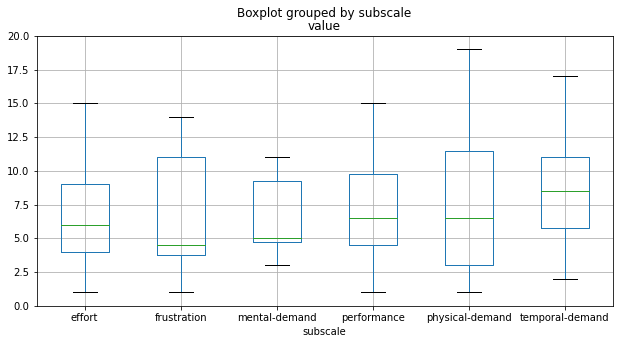

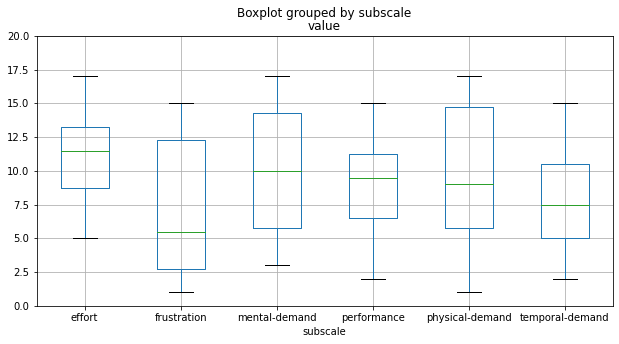

In [196]:

ax = tlx_data.query('mode == "normal"').boxplot("value", by="subscale", figsize=(10, 5))
ax.set_ylim(0, 20)
ax = tlx_data.query('mode == "drea"').boxplot("value", by="subscale", figsize=(10, 5))
ax.set_ylim(0, 20)

(0.0, 20.0)

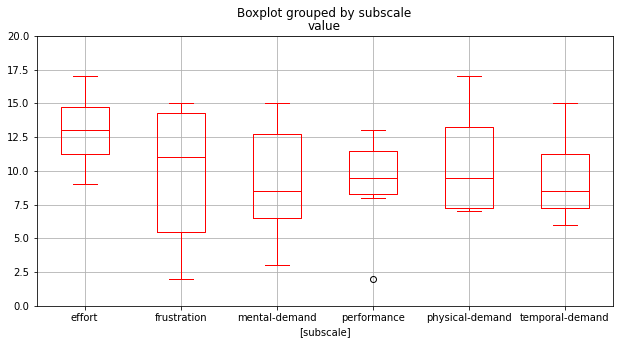

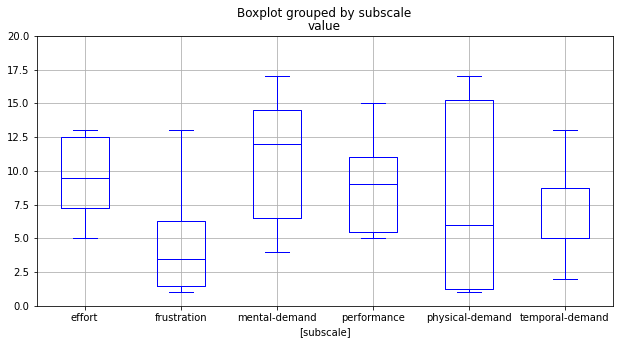

In [102]:
# Boxplot zeigt alle Antworten zum normalen Modus
# In Blau sind aktuell die Antworten zum normalen Modus von denen, die im drea Modus gestartet sind

ax = tlx_data.query("mode == 'drea' and subject not in @drea_ids").boxplot(column="value", by=["subscale"], figsize=[10,5], color="red")
ax.set_ylim(0, 20)

# tlx_data.query("mode == 'drea'").boxplot(column="value", by=["subscale"], figsize=[10,5], color="green")
ax = tlx_data.query("mode == 'drea' and subject in @drea_ids").boxplot(column="value", by=["subscale"], figsize=[10,5], color="blue")
ax.set_ylim(0, 20)

#tlx_data.query("mode == 'normal' and subject in @drea_ids").boxplot(column="value", by=["subscale"], figsize=[10,5], color="black")

In [104]:
print(tlx_data.query("mode == 'drea' and subject not in @drea_ids and subscale == 'temporal-demand'")["value"].describe())
print(tlx_data.query("mode == 'drea' and subject in @drea_ids and subscale == 'temporal-demand'")["value"].describe())

count     6.000000
mean      9.500000
std       3.391165
min       6.000000
25%       7.250000
50%       8.500000
75%      11.250000
max      15.000000
Name: value, dtype: float64
count     6.000000
mean      6.666667
std       4.033196
min       2.000000
25%       5.000000
50%       5.000000
75%       8.750000
max      13.000000
Name: value, dtype: float64


In [ ]:
normal_tlx = tlx_data.query("mode == 'normal' and subscale == 'temporal-demand'").describe()["value"]
drea_tlx = tlx_data.query("mode == 'drea' and subscale == 'temporal-demand'").describe()["value"]
print(f"Normaler TLX:\n{normal_tlx}")
print(f"\nDREA TLX:\n{drea_tlx}")
#tlx_data.query("mode == 'normal' and subject in @drea_ids and subscale == 'mental-demand'")

Normaler TLX:
count    12.000000
mean      8.500000
std       4.400413
min       2.000000
25%       5.750000
50%       8.500000
75%      11.000000
max      17.000000
Name: value, dtype: float64

DREA TLX:
count    12.000000
mean      8.083333
std       3.848455
min       2.000000
25%       5.000000
50%       7.500000
75%      10.500000
max      15.000000
Name: value, dtype: float64


<AxesSubplot:title={'center':'time'}, xlabel='mode'>

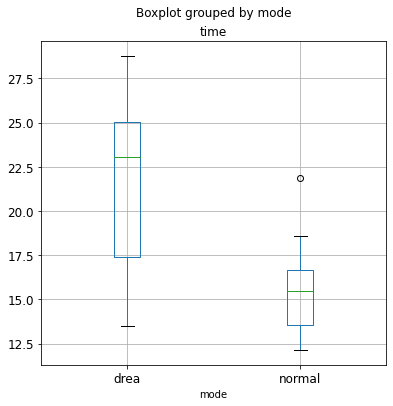

In [ ]:
df = pd.read_csv(path_to_csvs + "time.csv")
drea_time = df.query('mode == "drea"')
normal_time = df.query('mode == "normal"')

df.boxplot(column=["time"], by="mode", fontsize=12.0, figsize=[6,6])

<AxesSubplot:title={'center':'time'}, xlabel='mode'>

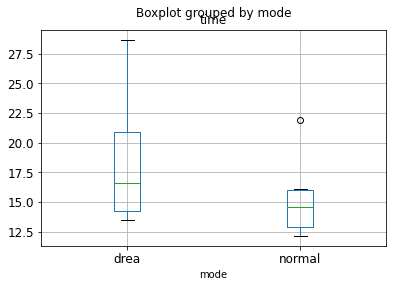

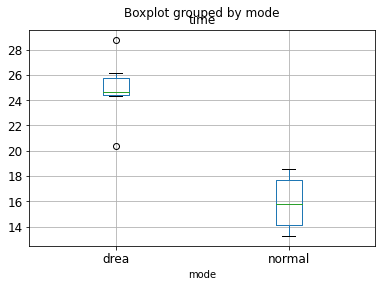

In [ ]:
age_filter = df["age"] < df.describe()["age"]["mean"]

anti_age_filter = df["age"] >= df.describe()["age"]["mean"]
df[age_filter].boxplot(column=["time"], by="mode", fontsize=12.0)
df[anti_age_filter].boxplot(column=["time"], by="mode", fontsize=12.0)

In [ ]:
male_data = df.query('sex == "male"')
female_data = df.query('sex == "female"')
df.boxplot(column="time", by=["sex", "mode"], fontsize=12.0, figsize=[8,6])

In [ ]:
print(df[age_filter].query('mode == "normal"').describe())
print(df[anti_age_filter].query('mode == "normal"').describe())

<AxesSubplot:title={'center':'time'}, xlabel='mode'>

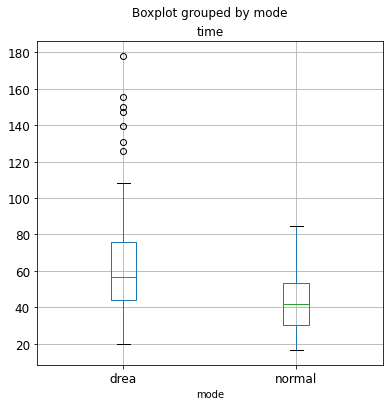

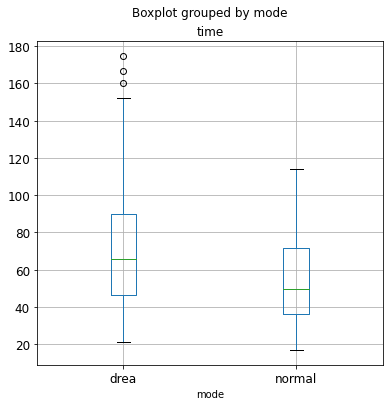

In [ ]:
drea_starters = df.query('id in @drea_ids')
drea_starters.boxplot(column=["time"], by="mode", fontsize=12.0, figsize=[6,6])
normal_starters = df.query('id in @normal_ids')
normal_starters.boxplot(column=["time"], by="mode", fontsize=12.0, figsize=[6,6])

In [ ]:
print(drea_time.describe())
normal_time.describe()

In [ ]:
drea_actions = count_actions_for_word(path_to_csvs + "06-drea.csv")
normal_actions = count_actions_for_word(path_to_csvs + "06-normal.csv")

     id    mode         word   tpa   tpc
0     1    drea  51674 Wiehl  0.66  6.04
1     1    drea   53119 Bonn  0.63  4.89
2     1    drea        Musik  0.75  6.15
3     1    drea       Eminem  0.80  6.37
4     1    drea  51063 Koeln  0.75  6.43
..   ..     ...          ...   ...   ...
451  12  normal     Jane Doe  0.40  6.24
452  12  normal         RPR1  0.62  5.40
453  12  normal      Italien  0.73  9.47
454  12  normal      Strasse  0.69  9.33
455  12  normal         SWR3  0.40  4.92

[456 rows x 5 columns]

(1, 'drea')
         id        tpa        tpc
count  19.0  19.000000  19.000000
mean    1.0   0.732632   7.426842
std     0.0   0.164176   2.436211
min     1.0   0.490000   4.570000
25%     1.0   0.620000   6.070000
50%     1.0   0.700000   6.490000
75%     1.0   0.815000   8.270000
max     1.0   1.080000  13.770000

(1, 'normal')
         id        tpa        tpc
count  19.0  19.000000  19.000000
mean    1.0   0.438947   4.833158
std     0.0   0.091827   0.825214
min     1.0   

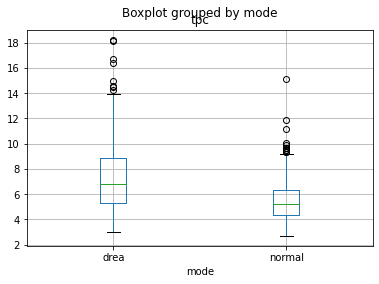

In [ ]:
# TPA ist die Zeit pro Action,
# in die Rechnung fließen nur die Aktionen bis zur Eingabe des letzten notwendigen Buchstabens ein.

# TPC ist die Zeit pro Buchstabe.
# Es wird die Zeit durch die Anzahl an Buchstaben geteilt.


tp = pd.read_csv(path_to_csvs + "tpa-tpc.csv")
tp.boxplot(by="mode", column="tpc")

grouped = tp.groupby(by=["id", "mode"])
for name, group in grouped:
    print(f"\n{name}")
    print(group.describe())
#     print(grouped["tpc"].describe())

,id,sex,age,mode,word,length,time,actions
0,1,male,52,drea,Auto,4,67.775,69
1,1,male,52,drea,RPR1,4,50.803,53
2,1,male,52,drea,51063 Koeln,11,79.566,103
3,1,male,52,drea,54290 Trier,11,149.853,186
4,1,male,52,drea,Tanken,6,68.267,96
...,...,...,...,...,...,...,...,...
451,12,male,52,normal,53119 Bonn,10,49.265,119
452,12,male,52,normal,WDR 4,5,50.021,108
453,12,male,52,normal,Max Muster,10,83.244,143
454,12,male,52,normal,Radio,5,38.257,64


In [ ]:
grouped = actions.groupby(by="mode")
for name, group in grouped:
    time_sum = round(sum(group["time"]))
    if name == "drea":
        print(f"Drea: {16501 / time_sum}")  # Drehbewegung / Zeit in Sek
        print(f"Drea: {time_sum / 16501}")  # Zeit in Sek / Drehbewegung
    else:
        print(f"Normal: {22394 / time_sum}")
        print(f"Normal: {time_sum / 22394}")

Drea: 1.0805448235217079
Drea: 0.9254590630870856
Normal: 1.9948334224122573
Normal: 0.5012949897293918


In [4]:
actions = pd.read_csv(path_to_csvs + "word_speeds.csv")
sum_chars = 139 * 12
sum_drea_actions = sum(actions.query("mode == 'drea'")["actions"])
sum_normal_actions = sum(actions.query("mode == 'normal'")["actions"])
num_chars = 1

print(f"Drea: {sum_drea_actions}")
print(f"Normal: {sum_normal_actions}")
print(f"Abstand pro {num_chars} Buchstaben: {round(( (sum_normal_actions / sum_chars) - (sum_drea_actions / sum_chars) ) * num_chars, 2)}")
print(round((sum_normal_actions - sum_drea_actions) / 12))
# Herausfinden wie sich bei den Controllern die Zeit auf das Nachdenken und Handeln verteilt
# Mehrzeit die DREA benötigt / Anzahl an Drehungen

Drea: 16501
Normal: 22394
Abstand pro 1 Buchstaben: 3.53
491


In [17]:
actions.query('id == 6 and mode == "normal"')["actions"].sum()

1862

In [ ]:
avg = round(139 / 19, 2)
14 * 3.54

49.56